In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE
import string
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
from collections import Counter
from imblearn.under_sampling import NearMiss
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
df.head(-7)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8709,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
8710,Google says reports about launch of Circles so...,NaN,No emotion toward brand or product
8711,"Google says the future is all around you! (ie,...",NaN,No emotion toward brand or product
8712,"Google says the future is location, location, ...",NaN,No emotion toward brand or product


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [4]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [5]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
pos_neg = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [8]:
pos_neg = pos_neg[pos_neg['is_there_an_emotion_directed_at_a_brand_or_product'] != "No emotion toward brand or product"]

### Heavily imbalanced datset

In [9]:
pos_neg.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

Positive emotion    0.840363
Negative emotion    0.159637
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

### More Data Cleaning

In [10]:
pos_neg = pos_neg.drop('emotion_in_tweet_is_directed_at', axis=1)
pos_neg = pos_neg.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product':'target'})
pos_neg.head()

,text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [11]:
def remove_ats_and_hashtags(text):
    entity_prefixes = ['@','#','�']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [12]:
pos_neg['text'] = pos_neg['text'].map(remove_ats_and_hashtags)

In [13]:
pos_neg.replace({'Negative emotion' : 0, 'Positive emotion' : 1}, inplace=True)

In [14]:
pos_neg['text'] = pos_neg['text'].str.lower()

In [15]:
pos_neg.head()

,text,target
0,i have a 3g iphone after 3 hrs tweeting at aus...,0
1,know about awesome ipad iphone app that you ll...,1
2,can not wait for 2 also they should sale them ...,1
3,i hope this year s festival isn t as crashy as...,0
4,great stuff on fri marissa mayer google tim o ...,1


### Exploring our Words

In [16]:
pos_neg['text_tokenized'] = pos_neg['text'].apply(word_tokenize)

In [17]:
pos_neg_freq_dist = FreqDist(pos_neg['text_tokenized'].explode())

In [18]:
def visualize_top_20(freq_dist, title):

    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
#     ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

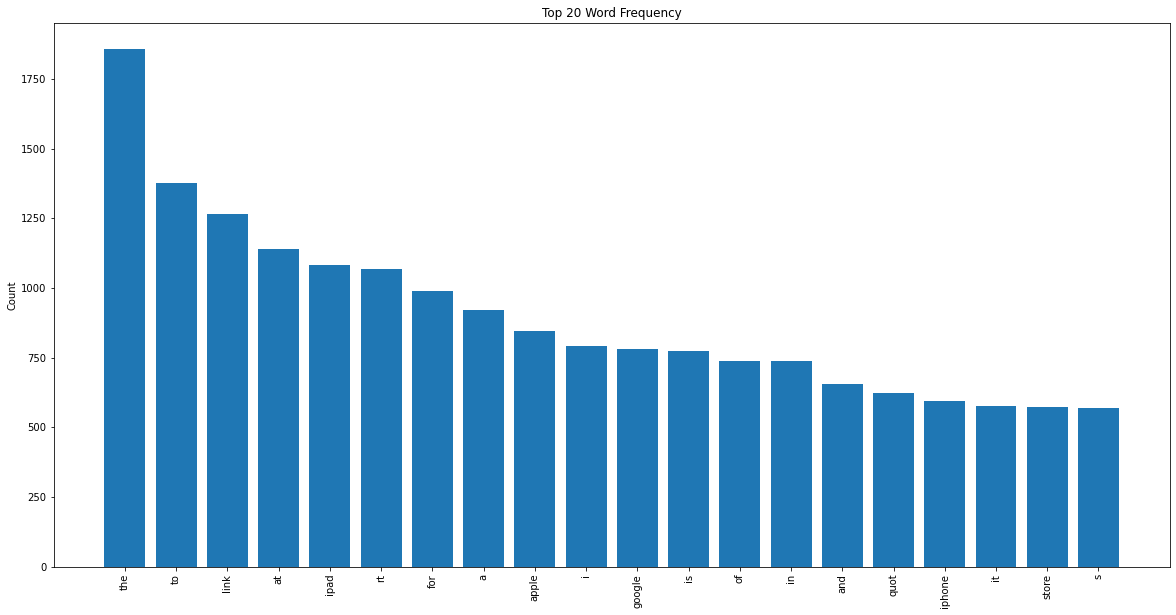

In [19]:
visualize_top_20(pos_neg_freq_dist, "Top 20 Word Frequency")

### Remove Stopwords

In [20]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
new_stops = ('quot', 'rt', 'i')
stopwords_list += list(new_stops)

In [21]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stops_rmv_list = [token for token in token_list if token not in stopwords_list]
    return stops_rmv_list

In [22]:
pos_neg['stopwords_removed'] = pos_neg['text_tokenized'].apply(remove_stopwords)

In [23]:
pos_neg.stopwords_removed.head()

0    [3g, iphone, 3, hrs, tweeting, austin, dead, n...
1    [know, awesome, ipad, iphone, app, likely, app...
2                                [wait, 2, also, sale]
3    [hope, year, festival, crashy, year, iphone, app]
4    [great, stuff, fri, marissa, mayer, google, ti...
Name: stopwords_removed, dtype: object

### Remove numbers and single letters

In [24]:
pattern = "([a-z]{2,})"
regex_tokenizer = RegexpTokenizer(pattern)

In [25]:
pos_neg['regex_text'] = [' '.join(text) for text in pos_neg.stopwords_removed]

In [26]:
pos_neg['regex_text_tokenized'] = [regex_tokenizer.tokenize(text) for text in pos_neg['regex_text']]

In [27]:
pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",3g iphone 3 hrs tweeting austin dead need upgr...,"[iphone, hrs, tweeting, austin, dead, need, up..."
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app..."
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait 2 also sale,"[wait, also, sale]"
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]"
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti..."


In [28]:
pos_neg['regex_text'] = [' '.join(text) for text in pos_neg.regex_text_tokenized]

In [29]:
pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone hrs tweeting austin dead need upgrade p...,"[iphone, hrs, tweeting, austin, dead, need, up..."
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app..."
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]"
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]"
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti..."


### Stem words

In [30]:
snow_stemmer = SnowballStemmer(language="english")

pos_neg['stemmed_text'] = [snow_stemmer.stem(text) for text in pos_neg['regex_text']]

In [31]:
pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized,stemmed_text
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone hrs tweeting austin dead need upgrade p...,"[iphone, hrs, tweeting, austin, dead, need, up...",iphone hrs tweeting austin dead need upgrade p...
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]",wait also sal
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...


### Lemmatize words

In [32]:
lemmer = WordNetLemmatizer()

pos_neg['lemmed_text'] = [lemmer.lemmatize(text) for text in pos_neg['regex_text']]

In [33]:
pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized,stemmed_text,lemmed_text
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone hrs tweeting austin dead need upgrade p...,"[iphone, hrs, tweeting, austin, dead, need, up...",iphone hrs tweeting austin dead need upgrade p...,iphone hrs tweeting austin dead need upgrade p...
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]",wait also sal,wait also sale
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,hope year festival crashy year iphone app
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...


### Train Test Split

In [34]:
X = pos_neg.drop(['target'], axis=1)
y = pos_neg['target']

In [35]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
y_train.value_counts(normalize=True)

1    0.841084
0    0.158916
Name: target, dtype: float64

### Determine number of features for vectorization

In [37]:
lens = [len(list(text)) for text in pos_neg.lemmed_text]
mean_lens = sum(lens) / len(lens)
mean_lens

58.300527240773285

### Build and score a baseline model

In [38]:
tfidf = TfidfVectorizer(max_features=60)

X_train_vectorized = tfidf.fit_transform(X_train['lemmed_text'])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,amp,android,app,apple,apps,around,austin,awesome,called,check,...,store,sxsw,temporary,think,time,today,use,users,via,want
0,0.0000,0.788859,0.614575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1,0.4543,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
3,0.0000,0.000000,0.749520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
4,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2727,0.0000,0.000000,0.633316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2728,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7453
2729,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000


In [39]:
smote = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

In [40]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

baseline_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_resampled, y_train_resampled)
baseline_cv

array([0.65614799, 0.66594124, 0.68443961, 0.67573449, 0.68300654])

In [41]:
print("Baseline:         ", baseline_cv.mean())

Baseline:          0.6730539731307829


In [42]:
X_test_vectorized = tfidf.fit_transform(X_test['lemmed_text'])
X_test_preds = baseline_model.predict(X_test_vectorized)

print(classification_report(y_test, X_test_preds))

              precision    recall  f1-score   support

           0       0.15      0.37      0.22       111
           1       0.83      0.60      0.70       572

    accuracy                           0.56       683
   macro avg       0.49      0.49      0.46       683
weighted avg       0.72      0.56      0.62       683



/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


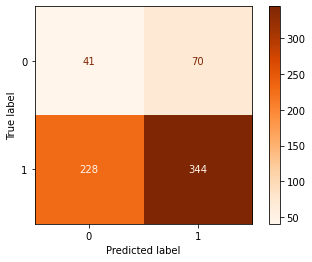

In [43]:
plot_confusion_matrix(baseline_model, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [44]:
clf = svm.SVC()
clf.fit(X_train_resampled, y_train_resampled)
clf_cv = cross_val_score(clf, X_train_resampled, y_train_resampled)
clf_cv

array([0.7921654 , 0.83786725, 0.83242655, 0.82698585, 0.83986928])

In [45]:
print("Baseline:  ", baseline_cv.mean())
print("SVM:       ", clf_cv.mean())

Baseline:   0.6730539731307829
SVM:        0.8258628660024039


In [46]:
X_test_vectorized_SVM = tfidf.fit_transform(X_test['lemmed_text'])
SVM_test_preds = clf.predict(X_test_vectorized)

print(classification_report(y_test, SVM_test_preds))

              precision    recall  f1-score   support

           0       0.17      0.18      0.17       111
           1       0.84      0.83      0.83       572

    accuracy                           0.72       683
   macro avg       0.50      0.50      0.50       683
weighted avg       0.73      0.72      0.73       683



/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


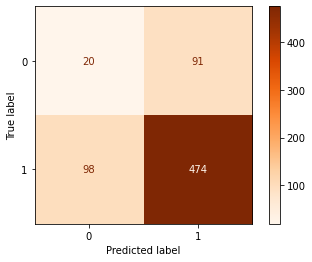

In [47]:
plot_confusion_matrix(clf, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [48]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train_resampled, y_train_resampled)
# Evaluate the classifier on X_train_vectorized and y_train
knn_5_cv = cross_val_score(knn_5, X_train_resampled, y_train_resampled)
knn_5_cv

array([0.7508161 , 0.78237214, 0.7921654 , 0.77149075, 0.75599129])

In [49]:
print("Baseline:  ", baseline_cv.mean())
print("SVM:       ", clf_cv.mean())
print("KNN 5:     ", knn_5_cv.mean())

Baseline:   0.6730539731307829
SVM:        0.8258628660024039
KNN 5:      0.7705671362971497


In [50]:
knn_5_preds = knn_5.predict(X_test_vectorized)

print(classification_report(y_test, knn_5_preds))

              precision    recall  f1-score   support

           0       0.17      0.55      0.26       111
           1       0.84      0.47      0.60       572

    accuracy                           0.48       683
   macro avg       0.51      0.51      0.43       683
weighted avg       0.73      0.48      0.55       683



/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


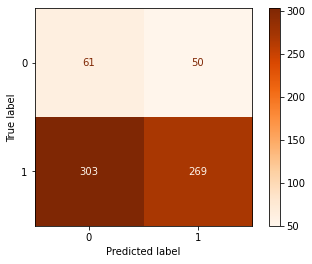

In [51]:
plot_confusion_matrix(knn_5, X_test_vectorized, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [52]:
tfidf_text = TfidfVectorizer(max_features=60)

X_train_vectorized_text = tfidf_text.fit_transform(X_train['text'])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_text, columns=tfidf.get_feature_names())

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,amp,android,app,apple,apps,around,austin,awesome,best,called,...,store,sxsw,temporary,thanks,think,time,today,via,wins,would
0,0.0,0.550306,0.000000,0.000000,0.000000,0.534685,0.415793,0.0,0.0,0.291630,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000
1,0.0,0.000000,0.529191,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.59127,0.00000,0.000000,0.00000
2,0.0,0.000000,0.000000,0.000000,0.385530,0.000000,0.000000,0.0,0.0,0.301214,...,0.0,0.505368,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.452735,0.0,0.0,0.317540,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.58988
4,0.0,0.000000,0.000000,0.000000,0.373507,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.481385,0.00000
2727,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.572227,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000
2728,0.0,0.000000,0.000000,0.318595,0.561347,0.000000,0.000000,0.0,0.0,0.219290,...,0.0,0.000000,0.0,0.211116,0.0,0.0,0.00000,0.33615,0.000000,0.00000
2729,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.00000


In [53]:
smote_text = SMOTE(k_neighbors=5)
X_train_resampled_text, y_train_resampled_text = smote_text.fit_resample(X_train_vectorized_text, y_train)

In [54]:
clf_text = svm.SVC()
clf_text.fit(X_train_resampled_text, y_train_resampled_text)
clf_text_cv = cross_val_score(clf_text, X_train_resampled_text, y_train_resampled_text)
clf_text_cv

array([0.79760609, 0.95429815, 0.94994559, 0.94015234, 0.95533769])

In [55]:
print("Baseline:  ", baseline_cv.mean())
print("SVM:       ", clf_cv.mean())
print("KNN 5:     ", knn_5_cv.mean())
print("SVM_text:  ", clf_text_cv.mean())

Baseline:   0.6730539731307829
SVM:        0.8258628660024039
KNN 5:      0.7705671362971497
SVM_text:   0.9194679733820743


In [56]:
X_test_vectorized_text = tfidf_text.fit_transform(X_test['text'])
SVM_text_preds = clf_text.predict(X_test_vectorized_text)

print(classification_report(y_test, SVM_text_preds))

              precision    recall  f1-score   support

           0       0.24      0.07      0.11       111
           1       0.84      0.96      0.90       572

    accuracy                           0.81       683
   macro avg       0.54      0.51      0.50       683
weighted avg       0.74      0.81      0.77       683



/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


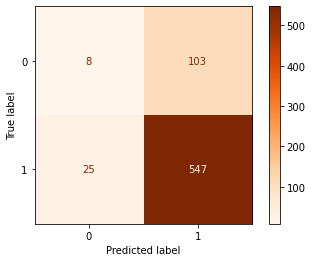

In [57]:
plot_confusion_matrix(clf_text, X_test_vectorized_text, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [58]:
tfidf_regex_text = TfidfVectorizer(max_features=60)

X_train_vectorized_regex_text = tfidf_regex_text.fit_transform(X_train['regex_text'])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_regex_text, columns=tfidf.get_feature_names())

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,amp,android,app,apple,apps,around,austin,awesome,best,called,...,store,sxsw,temporary,thanks,think,time,today,via,wins,would
0,0.0000,0.788859,0.614575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1,0.4543,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
3,0.0000,0.000000,0.749520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
4,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2727,0.0000,0.000000,0.633316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2728,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7453
2729,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000


In [59]:
smote_regex_text = SMOTE(k_neighbors=5)
X_train_resampled_regex_text, y_train_regex_resampled_text = smote_regex_text.fit_resample(X_train_vectorized_regex_text, y_train)

In [60]:
clf_regex_text = svm.SVC()
clf_regex_text.fit(X_train_resampled_regex_text, y_train_regex_resampled_text)
clf_regex_text_cv = cross_val_score(clf_regex_text, X_train_resampled_regex_text, y_train_regex_resampled_text)
clf_regex_text_cv

array([0.79107726, 0.84874864, 0.83460283, 0.83242655, 0.8540305 ])

In [61]:
print("Baseline:       ", baseline_cv.mean())
print("SVM:            ", clf_cv.mean())
print("KNN 5:          ", knn_5_cv.mean())
print("SVM_text:       ", clf_text_cv.mean())
print("SVM_regex_text: ", clf_regex_text_cv.mean())

Baseline:        0.6730539731307829
SVM:             0.8258628660024039
KNN 5:           0.7705671362971497
SVM_text:        0.9194679733820743
SVM_regex_text:  0.8321771557129682


In [62]:
X_test_vectorized_regex_text = tfidf_regex_text.fit_transform(X_test['regex_text'])
SVM_regex_text_preds = clf_regex_text.predict(X_test_vectorized_regex_text)

print(classification_report(y_test, SVM_regex_text_preds))

              precision    recall  f1-score   support

           0       0.16      0.18      0.17       111
           1       0.84      0.81      0.82       572

    accuracy                           0.71       683
   macro avg       0.50      0.50      0.50       683
weighted avg       0.73      0.71      0.72       683



/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


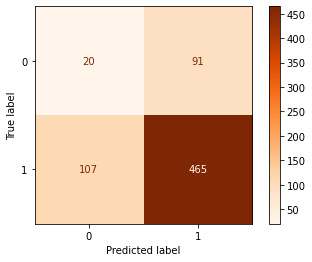

In [63]:
plot_confusion_matrix(clf_regex_text, X_test_vectorized_regex_text, y_test, cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()